<a href="https://colab.research.google.com/github/xu62u4u6/bioInfo_foundations/blob/main/RNA_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#plt.style.use("seaborn-v0_8")
os.chdir('/content/drive/Shareddrives/寶可夢大集結/生醫數據實作/作業/TCGA_LUAD')
sns.set(style="whitegrid")
tumor_df = pd.read_csv('tumor_tpm_df.csv', index_col=0)
normal_df = pd.read_csv('normal_tpm_df.csv', index_col=0)

In [ ]:
def boxplot_plot(df):
    log_df = np.log(df + 1)  # 避免log(0)的情况
    genes_min = df.min(axis=1)
    genes_max = df.max(axis=1)
    scaled_log_tumor_df = (df - genes_min)/(genes_max - genes_min)
    plt.figure(figsize=(20, 5))
    ax = plt.boxplot(scaled_log_tumor_df)
    return scaled_log_tumor_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def log_scaling_boxplot(df, title):
    scaler = MinMaxScaler()
    log_df = np.log(df + 1)  # Avoid log(0) situation
    scaled_log_df = scaler.fit_transform(log_df)
    plt.figure(figsize=(20, 5))
    ax = plt.boxplot(scaled_log_df, labels=df.columns)
    plt.xticks(rotation=45, ha='right')
    #plt.xticks(rotation=90)
    plt.xlabel("Case ID")
    plt.ylabel("Scaled Log Values")
    plt.title(f"Boxplot of Scaled {title} Log-Transformed Data")
    plt.show()

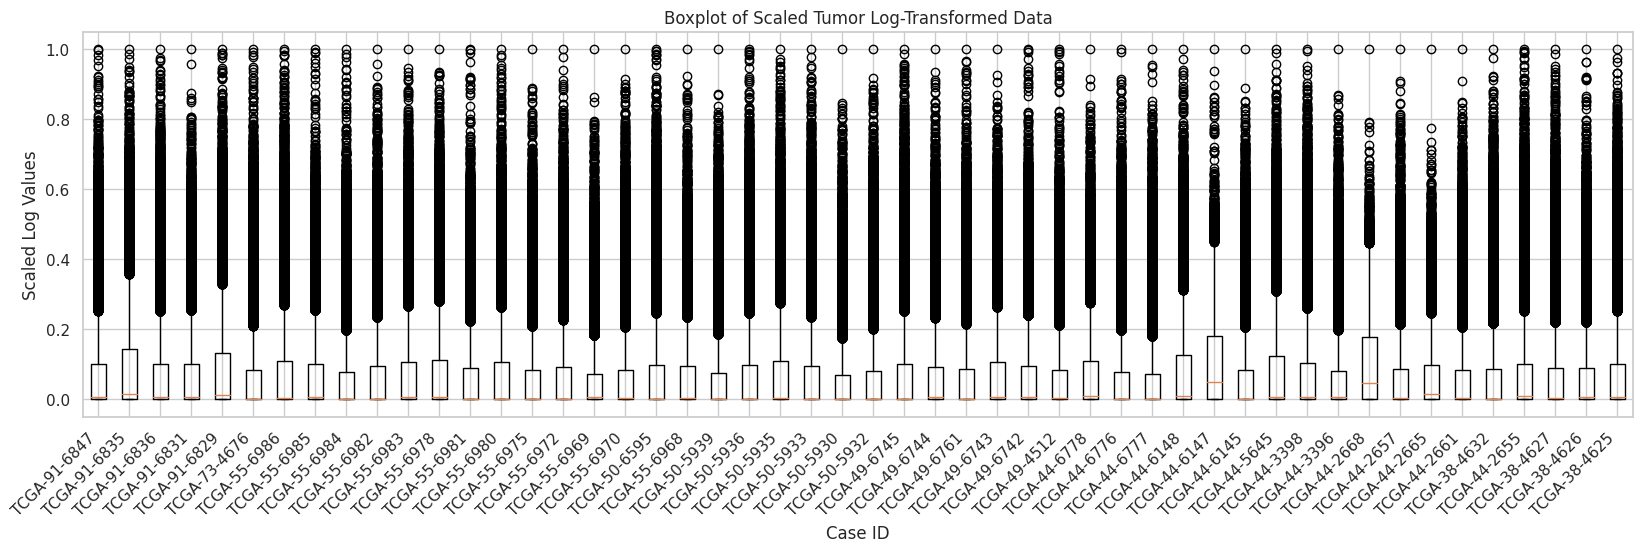

In [ ]:
log_scaling_boxplot(tumor_df, "Tumor")

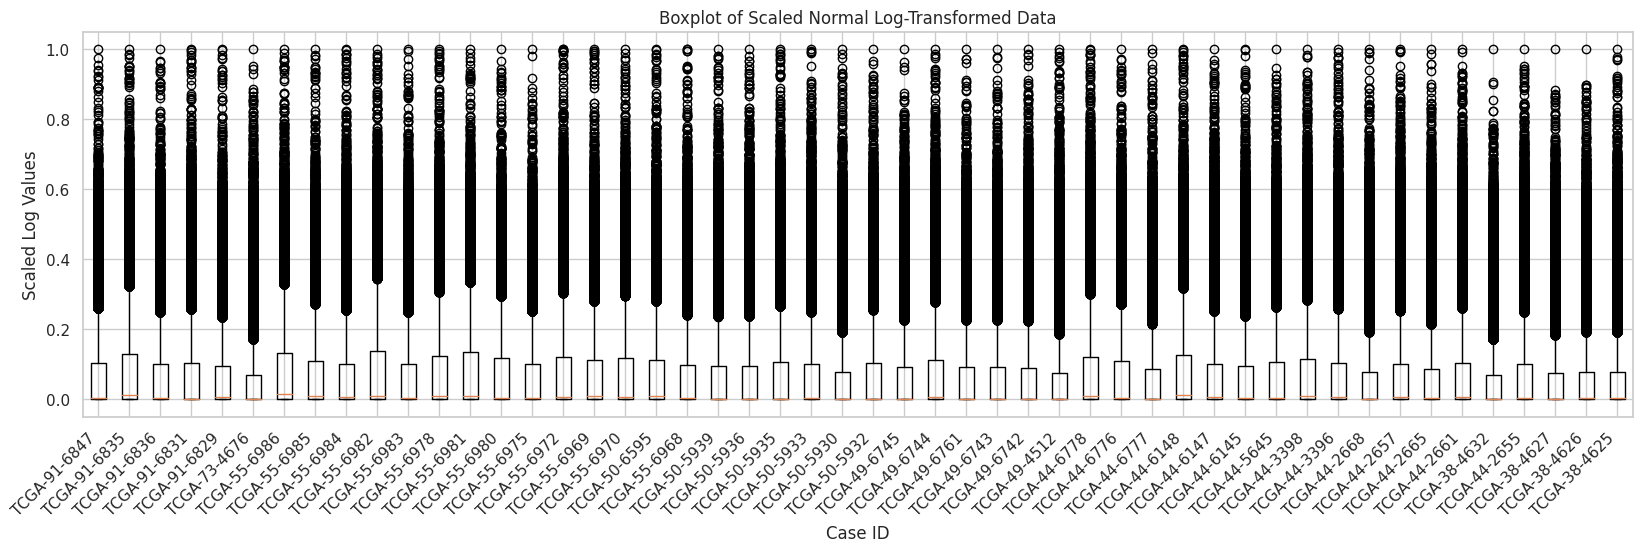

In [ ]:
log_scaling_boxplot(normal_df, "Normal")

In [ ]:
def genes_PCA(tumor_df, normal_df, title):
    pca = PCA(n_components=2)
    tumor_normal_df = pd.concat([tumor_df, normal_df], axis=1)
    pca = pca.fit(tumor_normal_df.T.values)
    pca_result_tumor = pca.transform(tumor_df.T.values)
    pca_result_normal = pca.transform(normal_df.T.values)
    plt.scatter(pca_result_normal[:, 0], pca_result_normal[:, 1], label="Normal")
    plt.scatter(pca_result_tumor[:, 0], pca_result_tumor[:, 1], label="Tumor")
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})")
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})")
    plt.title(title)
    plt.legend()
    plt.show()


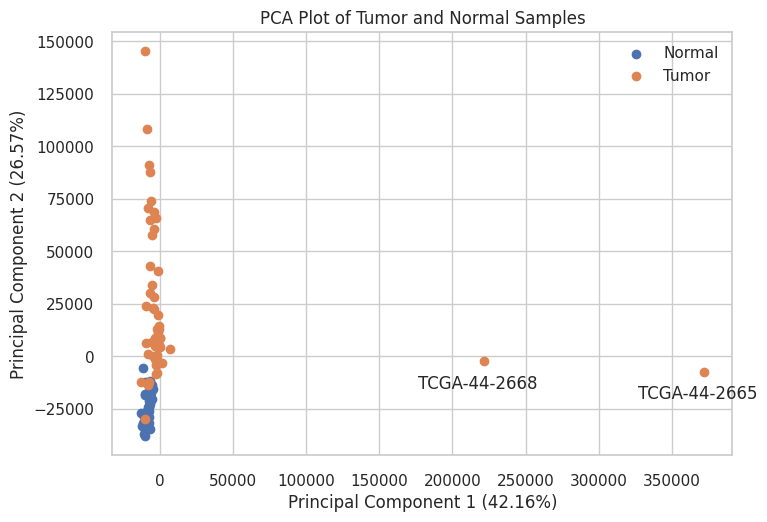

In [ ]:
# tumor/normal PCA
tumor_normal_df = pd.concat([tumor_df, normal_df], axis=1)
pca_tumor_normal = PCA(n_components=2)
pca_tumor_normal = pca_tumor_normal.fit(tumor_normal_df.T.values)

pca_result_tumor = pca_tumor_normal.transform(tumor_df.T.values)
pca_result_normal = pca_tumor_normal.transform(normal_df.T.values)

plt.scatter(pca_result_normal[:, 0], pca_result_normal[:, 1], label="Normal")  # Add label parameter instead of lebel
plt.scatter(pca_result_tumor[:, 0], pca_result_tumor[:, 1], label="Tumor")  # Add label parameter instead of lebel

outliers_filter_indices = np.where(pca_result_tumor[:, 0] > 200000)[0]
for ind in outliers_filter_indices:
   plt.text(pca_result_tumor[ind, 0]-45000, pca_result_tumor[ind, 1]-13000, tumor_df.columns[ind])

plt.xlabel(f"Principal Component 1 ({pca_tumor_normal.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"Principal Component 2 ({pca_tumor_normal.explained_variance_ratio_[1]:.2%})")
plt.title("PCA Plot of Tumor and Normal Samples")
plt.legend()
plt.show()

In [ ]:
# drop 2 outliers
tumor_df = tumor_df.drop(["TCGA-44-2668", "TCGA-44-2665"], axis=1)
normal_df = normal_df.drop(["TCGA-44-2668", "TCGA-44-2665"], axis=1)

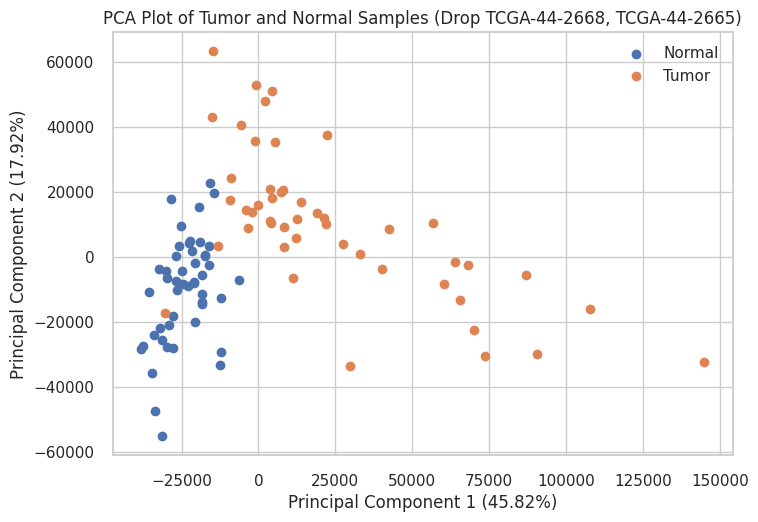

In [ ]:
# drop outliers tumor/normal PCA
genes_PCA(tumor_df, normal_df, "PCA Plot of Tumor and Normal Samples (Drop TCGA-44-2668, TCGA-44-2665)")

In [ ]:
# protein coding gene
protein_coding_gene = "protein_coding_gene.txt"
protein_coding_gene_df = pd.read_csv(protein_coding_gene, sep="\t")#.loc[:, ["symbol", "ensembl_gene_id"]]
protein_coding_gene_df = protein_coding_gene_df.dropna()
protein_coding_gene_list = protein_coding_gene_df.loc[:, "Gene stable ID"].unique()
coding_tumor_df = tumor_df.loc[tumor_df.index.isin(protein_coding_gene_list), :]
coding_normal_df = normal_df.loc[tumor_df.index.isin(protein_coding_gene_list), :]

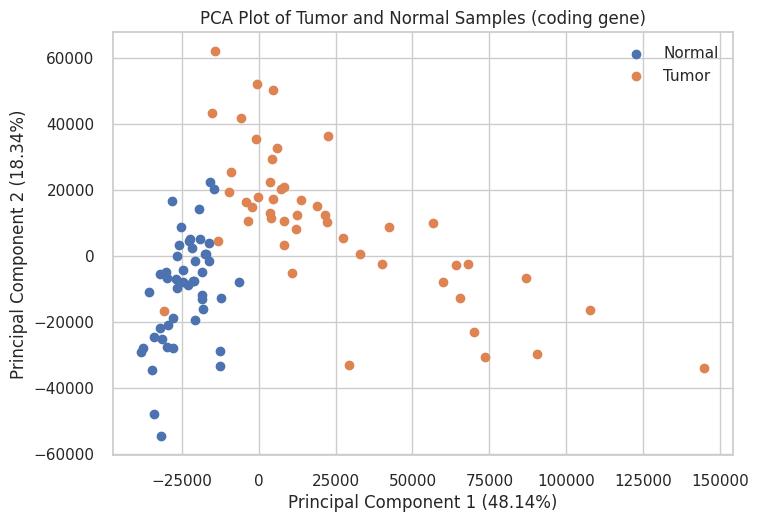

In [ ]:
# coding tumor/normal
genes_PCA(coding_tumor_df, coding_normal_df, "PCA Plot of Tumor and Normal Samples (coding gene)")

In [ ]:
def gene_distribution(ENSG_id, tumor_df, normal_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log(normal_df + 1).loc[ENSG_id, :], kde=True, label="Normal", stat="density")
    sns.histplot(np.log(tumor_df + 1).loc[ENSG_id, :], kde=True, label="Tumor", stat="density")
    plt.title('Gene Expression Distribution')
    plt.xlabel('Gene Expression Level')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

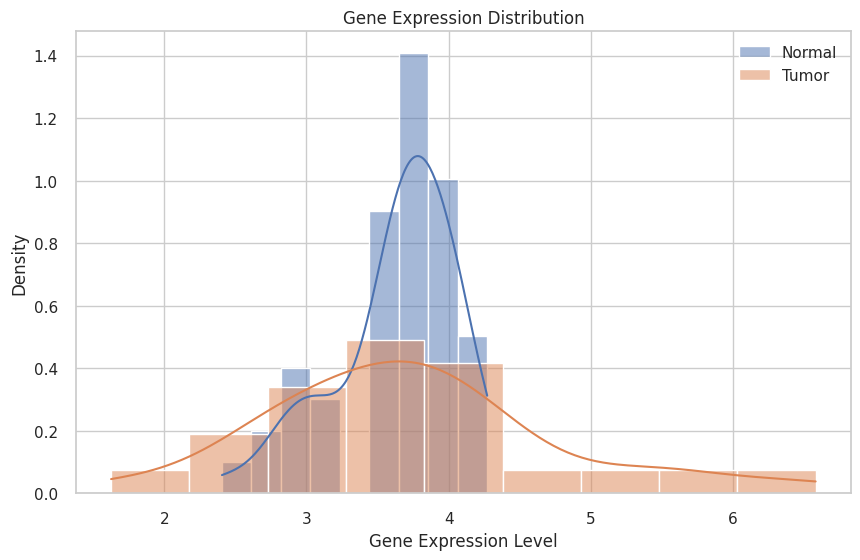

In [ ]:
# EGFR
gene_distribution("ENSG00000146648", tumor_df, normal_df)

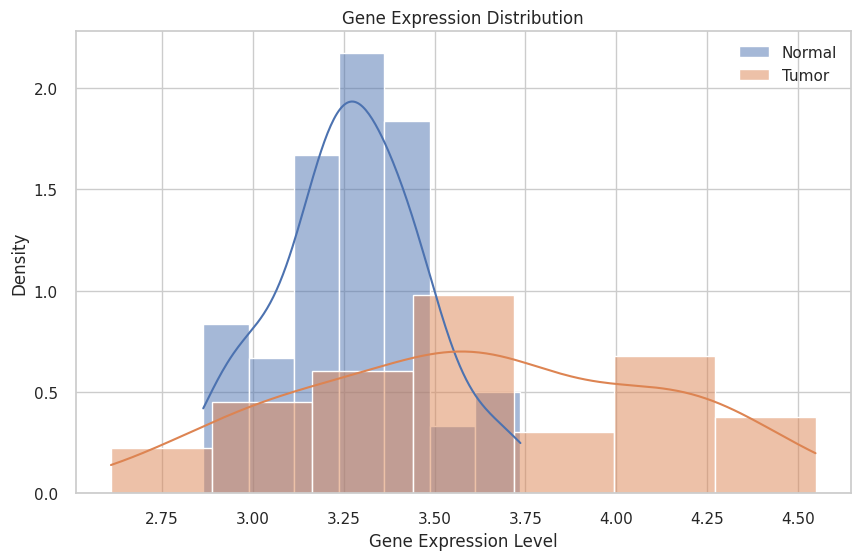

In [ ]:
# TP53
gene_distribution("ENSG00000141510", tumor_df, normal_df)

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection, multipletests

In [ ]:
tumor_df = tumor_df.fillna(0)
normal_df = normal_df.fillna(0)

# mannwhitney U-test
u_stat, p_values = stats.mannwhitneyu(tumor_df, normal_df, axis=1, alternative='two-sided')
# FDR 校正
q_values = multipletests(p_values, method='fdr_bh')[1]
q_values

array([3.57315937e-08, 7.62750554e-02, 5.90294658e-02, ...,
       1.00000000e+00, 1.97940192e-04, 4.48467066e-03])

In [ ]:
# fold change
fold_change = tumor_df/normal_df
fold_change = fold_change.replace(np.inf, 0)
fold_change = fold_change.fillna(0)
log2_fold_change = np.where(fold_change==0, 0, np.log2(fold_change))
gene_log_fold_change_mean = log2_fold_change.mean(axis=1)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


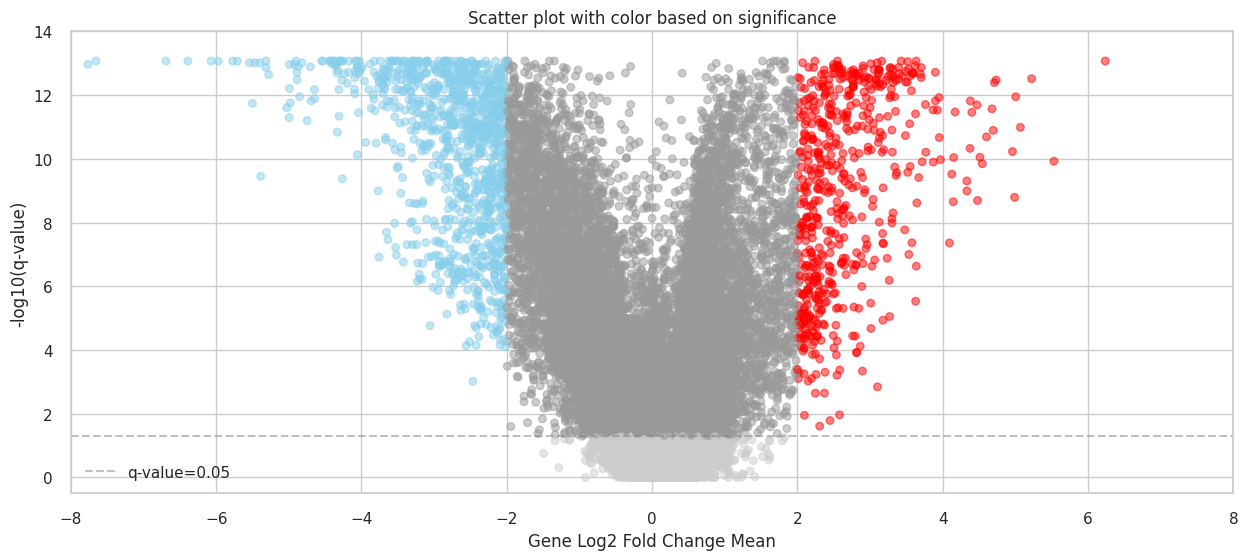

In [ ]:
# info df
info_df = pd.DataFrame(index=tumor_df.index)
info_df["gene_log_fold_change_mean"] = gene_log_fold_change_mean
info_df["p_values"] = p_values
info_df["q_values"] = q_values
info_df["color"] = "#CCCCCC"
info_df.loc[info_df.q_values < 0.05, "color"] = "#999999"
info_df.loc[(info_df.gene_log_fold_change_mean > 2) & (info_df.q_values < 0.05), "color"] = "red"
info_df.loc[(info_df.gene_log_fold_change_mean < -2) & (info_df.q_values < 0.05), "color"] = "skyblue"

plt.figure(figsize=(15, 6))
plt.scatter(info_df.gene_log_fold_change_mean, -np.log10(info_df.q_values), color=info_df.color, alpha=0.5, s=30)
plt.axhline(-np.log10(0.05), color='gray', linestyle='--', label='q-value=0.05', alpha=0.5)
plt.ylim(-0.5, 14)
plt.xlim(-8, 8)

plt.xlabel('Gene Log2 Fold Change Mean')
plt.ylabel('-log10(q-value)')
plt.title('Scatter plot with color based on significance')
plt.legend()
plt.show()

In [ ]:
#　Print DEgenes
hc_genes = info_df[q_values<0.05]
degenes = hc_genes[abs(hc_genes.gene_log_fold_change_mean) >= 2]
sorted_hc_genes = hc_genes.sort_values("gene_log_fold_change_mean")
sorted_hc_genes.head(5)

,gene_log_fold_change_mean,p_values,q_values,color
gene_id,,,,
ENSG00000108576,-7.764913,2.070340e-16,1.092060e-13,skyblue
ENSG00000168484,-7.655082,3.666186e-17,8.524589e-14,skyblue
ENSG00000204305,-6.692047,3.234613e-17,8.524589e-14,skyblue
ENSG00000066405,-6.390878,5.673650e-17,8.524589e-14,skyblue
ENSG00000243566,-6.069600,3.902799e-17,8.524589e-14,skyblue


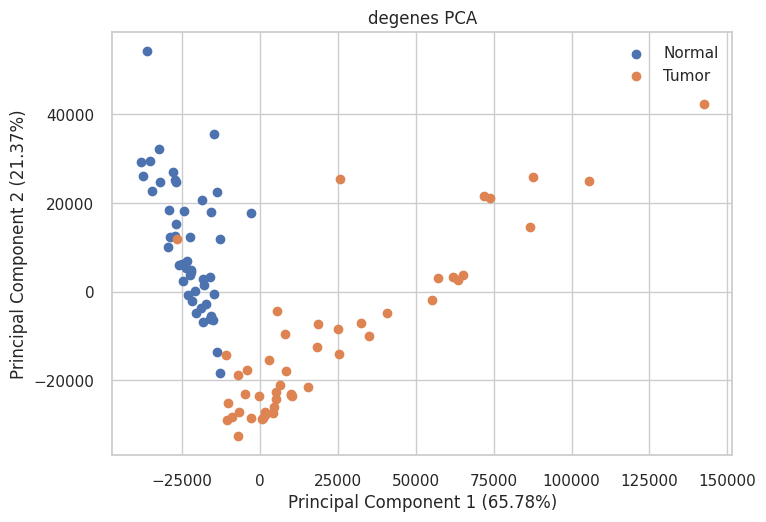

In [ ]:
degenes_tumor_df = tumor_df[tumor_df.index.isin(degenes.index)]
degenes_normal_df = normal_df[normal_df.index.isin(degenes.index)]
genes_PCA(degenes_tumor_df, degenes_normal_df, "degenes PCA")

In [ ]:
sorted_hc_genes.head(3)

,gene_log_fold_change_mean,p_values,q_values,color
gene_id,,,,
ENSG00000108576,-7.764913,2.070340e-16,1.092060e-13,skyblue
ENSG00000168484,-7.655082,3.666186e-17,8.524589e-14,skyblue
ENSG00000204305,-6.692047,3.234613e-17,8.524589e-14,skyblue


In [ ]:
sorted_hc_genes.tail(3)

,gene_log_fold_change_mean,p_values,q_values,color
gene_id,,,,
ENSG00000099953,5.223889,1.700076e-15,3.060137e-13,red
ENSG00000060718,5.531318,3.201114e-12,1.191286e-10,red
ENSG00000147689,6.235882,1.053980e-16,8.524589e-14,red
